In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2
lumi = 137000 #in pb-1


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/00
3.6.8 (default, Apr 25 2019, 21:02:35) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [16]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
# fpath_sig =OrderedDict()
# paths = ['/v10/v1/', '/v10/v3/','/v10/v2/','/v9/v2/']
# label = ['muonveto20','muonveto15','muonveto10','muonveto5']
paths = ['/v10/v1/', '/v10/v4/']
label = ['jetveto10','jetveto15']
paths = ['/v6/v1/', '/v10/v4/']
label = ['PUPPI','PF']
paths = ['/v10/v1/', '/v10/v7/']
label = ['lessstats','morestats']

paths = ['/v10/v6/', '/v10/v7/']
label = ['newAlg','oldAlg']
for i,p in enumerate(paths):
    path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16/'+p
    bkg_path = path+"/bkg/wH/normalized/"
    fpath_bkg['WJetsToLNu_'+label[i]] = bkg_path+"WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
    sig_path = path+'signals/wH/normalized/'
    fpath_bkg['bbbb_'+label[i]] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'



In [17]:
xsec = {}
xsec['bbbb'] = (5.328E-01 + 8.4E-01) *0.324
xsec['WJetsToLNu'] = 61526.7

NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#         tree_bkg[k] = root_dir['ntuples']['llp']
#         NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print ('weights',np.unique(a)*lumi)
#     print(lumi*xsec[k]/NEvents[k])
#     print(len(a)/ NEvents[k])
#     print(a.shape)


WJetsToLNu_newAlg /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16//v10/v6//bkg/wH/normalized/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root
weights [-50.44454965  50.44454965]
bbbb_newAlg /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16//v10/v6/signals/wH/normalized/WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root
weights [-1.58039884 -1.00285431  1.00285431  1.58039884]
WJetsToLNu_oldAlg /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16//v10/v7//bkg/wH/normalized/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root
weights [-50.44454965  50.44454965]
bbbb_oldAlg /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16//v10/v7/signals/wH/normalized/WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.r

In [18]:
trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
if wH:
    trigger_paths = [87,135] #PFMET120
else:
    trigger_paths = [177,362,87,135] #PFMET120

# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET


In [19]:
start_t = time.time()
nCsc = {}
nJets = {}
weight = {}
for k,T in tree_bkg.items():
    weight[k] = T.array('weight')*lumi
    nCsc[k] =T.array('nCsc')    
    nJets[k] =T.array('nJets')

print(time.time()-start_t)

2.7291224002838135


In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k == 'bbbb'
h[k] = create_TH2D(np.column_stack((cscClusterXSpread[k].flatten(),cscClusterSize[k].flatten())), axis_title = ['Moment','nCsc','Events'], binning=[50,0,120,50,0,300])

#     h[k] = create_TH1D( cscClusterMajorAxis[k].flatten(), axis_title=['Major Axis', 'Events'], name=k, binning=[20,0,5])
#     h[k] = create_TH1D( cscClusterMinorAxis[k].flatten(), axis_title=['Minor Axis', 'Events'], name=k, binning=[20,0,0.4])
#     h[k] = create_TH1D( cscClusterRadius[k].flatten(), axis_title=['Cluster Radius [cm]', 'Events'], name=k, binning=[15,0,300])
#     h[k] = create_TH1D( nCscClusters[k].flatten(), axis_title=['Number of Cluster', 'Events'], name=k, binning=[5,0,5])
#     h[k] = create_TH1D( cscClusterAxis[k].flatten(), axis_title=['Cluster Moment', 'Events'], name=k, binning=[30,0,10])
#     h[k] = create_TH1D( cscClusterSize[k].flatten(), axis_title=['Segmetns in Cluster', 'Events'], name=k, binning=[20,0,300])



h[k].SetLineColor(std_color_list[i])
leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
leg.Draw()


# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# nCsc

(314996,)
WJetsToLNu_newAlg
(901,)
bbbb_newAlg
(314996,)
WJetsToLNu_oldAlg
(901,)
bbbb_oldAlg
0.025420188903808594


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


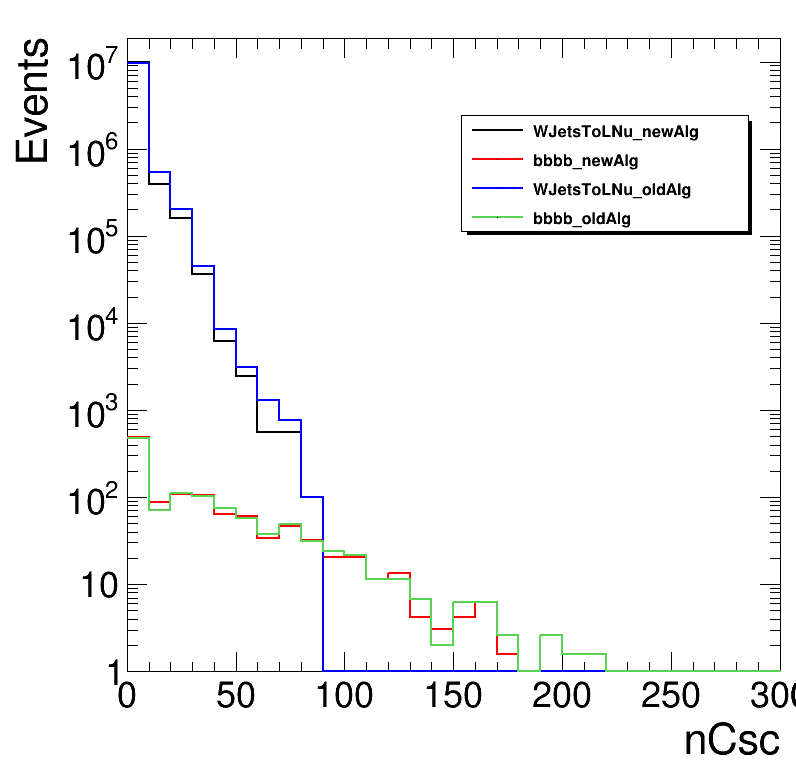

In [21]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
for k,v in nCsc.items():
#     print(v)
#     print(v)
    print(v.shape)
#     h[k] = create_TH1D( nCsc_recoJetVeto0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])
#     h[k] = create_TH1D( nJets[k], axis_title=['nCsc', 'Events'], name=k, binning=[25,0,25],weights = weight[k])
#     h[k] = create_TH1D( nCsc_JetVetoCluster0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[50,0,500],weights = weight[k])
#     print(nCsc_JetVetoCluster0p4_Me1112Veto[k])
#     h[k] = create_TH1D( v, axis_title=['nCsc', 'Events'], name=k, binning=[50,0,500],weights = weight[k])
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])


#     print(cscClusterMajorAxis[k])
#     h[k] = create_TH1D( cscClusterMajorAxis[k].flatten(), axis_title=['Major Axis', 'Events'], name=k, binning=[50,0,0.5])
#     h[k] = create_TH1D( cscClusterMinorAxis[k].flatten(), axis_title=['Minor Axis', 'Events'], name=k, binning=[50,0,0.3])
#     h[k] = create_TH1D( cscClusterRadius[k].flatten(), axis_title=['Cluster Radius [cm]', 'Events'], name=k, binning=[15,0,300])
#     h[k] = create_TH1D( cscClusterEtaSpread[k].flatten(), axis_title=['#sigma_{#eta}', 'Events'], name=k, binning=[25,0,0.3])
#     h[k] = create_TH1D( cscClusterPhiSpread[k].flatten(), axis_title=['#sigma_{#phi}', 'Events'], name=k, binning=[25,0,0.3])
#     h[k] = create_TH1D( cscClusterXSpread[k].flatten(), axis_title=['#sigma_{x} [cm]', 'Events'], name=k, binning=[25,0,100])
#     h[k] = create_TH1D( cscClusterYSpread[k].flatten(), axis_title=['#sigma_{y} [cm]', 'Events'], name=k, binning=[25,0,100])
#     h[k] = create_TH1D( cscClusterZSpread[k].flatten(), axis_title=['#sigma_{z} [cm]', 'Events'], name=k, binning=[25,0,125])


#     h[k] = create_TH1D( nCscClusters[k].flatten(), axis_title=['Number of Cluster', 'Events'], name=k, binning=[5,0,5])
#     h[k] = create_TH1D( cscClusterAxis[k].flatten(), axis_title=['Cluster Moment', 'Events'], name=k, binning=[30,0,10])
#     h[k] = create_TH1D( cscClusterSize[k].flatten(), axis_title=['Segments in Cluster', 'Events'], name=k, binning=[20,0,300])

    print(k)
#     print(nCscClusters[k].flatten())
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], k)
#     h[k].SetMaximum(50)
    h[k].SetMinimum(1)
    h[k].Draw('same hist')
#     h[k].GetXaxis()


    i+=1
leg.Draw()


# if setlog: 
c.SetLogy()
c.Draw()
print(time.time()-start_t)

# nCsc with different hit vetoing

In [25]:
pdgId = 13
if pdgId == 13:
    trigger_paths = [135]
else:
    trigger_paths = [87]
start_t = time.time()
weight = {}
nCsc = {}
nCsc_recoJetVeto0p4 = {}
nCsc_recoJetVeto0p8 = {}
nCsc_recoJetVeto0p4_Me11Veto = {}
nCsc_recoJetVeto0p8_Me11Veto = {}
nCsc_recoJetVeto0p4_Me1112Veto = {}
nCsc_recoJetVeto0p8_Me1112Veto = {}
event_Me1112Veto = {}
event_recoJetVeto0p4 = {}

nCsc_JetVetoCluster0p4 = {}
nCsc_JetVetoCluster0p4_Me1112Veto = {}

nCsc_JetVetoCluster0p4_Me11Veto = {}
nCsc_JetMuonVetoCluster0p4 = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}

nCsc0_JetMuonVetoCluster0p4 = {}
nCsc0_JetMuonVetoCluster0p4 = {}
nCsc0_JetMuonVetoCluster0p4_Me1112Veto = {}

nCsc_caloJetMuonVetoCluster0p4_Me1112Veto = {}
nCsc_caloJetVetoCluster0p4_Me1112Veto = {}
nCsc_caloJetMuonVetoCluster0p4 = {}
nCsc_caloJetVetoCluster0p4 = {}
nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto = {}

cscClusterR = {}
cscClusterX = {}
cscClusterY = {}

cscClusterMajorAxis = {}
cscClusterMinorAxis = {}
cscClusterRadius = {}
cscClusterSize = {}
nCscClusters = {}
cscClusterAxis = {}
cscClusterPhiSpread = {}
cscClusterEtaSpread = {}
# nSegments_cluster = {}
cscClusterXSpread = {}
cscClusterYSpread = {}
cscClusterZSpread = {}


for k,T in tree_bkg.items():
    
    hlt = T['HLTDecision'].array()
    print(len(hlt))
        # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
#     nLep = T.array('lepE')[np.logical_and(T.array('lepPassId'), T.array('lepPdgId') == pdgId)].count()
#     sel_ev = np.logical_and(sel_ev, nLep == 1)
#     print(T.array('lepGenId')[sel_ev])

#     sel_ev = np.logical_and(sel_ev, T.array('nCsc_JetMuonVetoCluster0p4_Me1112Veto') > 80)
#     print(np.count_nonzero(sel_ev))
    
    weight[k] = T.array('weight')[sel_ev]*lumi
    nCsc[k] =T.array('nCsc')[sel_ev]
#     nCsc_recoJetVeto0p4[k] =T.array('nCsc_recoJetVeto0p4')[sel_ev]
#     nCsc_recoJetVeto0p8[k] =T.array('nCsc_recoJetVeto0p8')[sel_ev]
#     nCsc_recoJetVeto0p4_Me11Veto[k] =T.array('nCsc_recoJetVeto0p4_Me11Veto')[sel_ev]
#     nCsc_recoJetVeto0p8_Me11Veto[k] =T.array('nCsc_recoJetVeto0p8_Me11Veto')[sel_ev]
#     nCsc_recoJetVeto0p4_Me1112Veto[k] =T.array('nCsc_recoJetVeto0p4_Me1112Veto')[sel_ev]
#     nCsc_recoJetVeto0p8_Me1112Veto[k] =T.array('nCsc_recoJetVeto0p8_Me1112Veto')[sel_ev]
#     nCsc0_JetMuonVetoCluster0p4[k] =T.array('nCsc0_JetMuonVetoCluster0p4')[sel_ev]
#     nCsc_JetVetoCluster0p4[k] =T.array('nCsc_JetVetoCluster0p4')[sel_ev]
#     nCsc_JetVetoCluster0p4_Me11Veto[k] =T.array('nCsc_JetVetoCluster0p4_Me11Veto')[sel_ev]
#     nCsc_JetVetoCluster0p4_Me1112Veto[k] =T.array('nCsc_JetVetoCluster0p4_Me1112Veto')[sel_ev]
    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_JetMuonVetoCluster0p4_Me1112Veto')[sel_ev]
#     nCsc_JetMuonVetoCluster0p4[k] =  T.array('nCsc_JetMuonVetoCluster0p4')[sel_ev]
#     if k[-2:]=='PF':
#         print(k)
#         nCsc_caloJetVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_caloJetVetoCluster0p4_Me1112Veto')[sel_ev]
#         nCsc_caloJetMuonVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_caloJetMuonVetoCluster0p4_Me1112Veto')[sel_ev]
#         nCsc_caloJetVetoCluster0p4[k] = T.array('nCsc_caloJetVetoCluster0p4')[sel_ev]
#         nCsc_caloJetMuonVetoCluster0p4[k] = T.array('nCsc_caloJetMuonVetoCluster0p4')[sel_ev]






#     event_recoJetVeto0p4[k] = T.array('event_recoJetVeto0p4')[sel_ev]
#     event_Me1112Veto[k] = T.array('event_Me1112Veto')[sel_ev]
    
    
#     cscClusterX[k] = T.array('cscClusterX')[sel_ev]
#     cscClusterY[k] = T.array('cscClusterY')[sel_ev]
#     cscClusterR[k] = np.sqrt(np.square(cscClusterX[k])+np.square(cscClusterY[k]))
#     sel_cluster = np.logical_and( T.array('cscClusterJetVeto'), T.array('cscClusterCaloJetVeto'))[sel_ev]
#     sel_cluster = np.logical_and( T.array('cscClusterMuonVeto')[sel_ev], sel_cluster)
#     sel_cluster = np.logical_and( sel_cluster, np.abs(T.array('cscClusterStation')[sel_ev]) != 12)
#     sel_cluster = np.logical_and( sel_cluster, np.abs(T.array('cscClusterStation')[sel_ev]) != 11)
#     nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto[k] = T.array('cscClusterSize')[sel_ev][sel_cluster]
#     nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto[k] = np.array([sum(a) for a in nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto[k]])
    
#         print( np.count_nonzero(T.array('cscClusterJetVeto')[T.array('cscClusterCaloJetVeto')]))


#     #cluster shapes
#     cscClusterXSpread[k] =  T.array('cscClusterXSpread')[sel_ev][sel_cluster]
#     cscClusterYSpread[k] =  T.array('cscClusterYSpread')[sel_ev][sel_cluster]
#     cscClusterZSpread[k] =  T.array('cscClusterZSpread')[sel_ev][sel_cluster]
#     cscClusterEtaSpread[k] =  T.array('cscClusterEtaSpread')[sel_ev][sel_cluster]
#     cscClusterPhiSpread[k] =  T.array('cscClusterPhiSpread')[sel_ev][sel_cluster]
#     cscClusterMajorAxis[k] =  T.array('cscClusterMajorAxis')[sel_ev][sel_cluster]
#     cscClusterMinorAxis[k] =  T.array('cscClusterMinorAxis')[sel_ev][sel_cluster]
#     cscClusterAxis[k] = np.sqrt(cscClusterMajorAxis[k]* cscClusterMajorAxis[k] + cscClusterMinorAxis[k] * cscClusterMinorAxis[k])
#     cscClusterRadius[k] =  T.array('cscClusterRadius')[sel_ev][sel_cluster]
#     cscClusterSize[k] =  T.array('cscClusterSize')[sel_ev][sel_cluster]
#     nCscClusters[k] =  cscClusterSize[k].counts
    print (k,len(weight[k]))
print(time.time()-start_t)

1179739
WJetsToLNu_newAlg 314996
3917
bbbb_newAlg 901
1179739
WJetsToLNu_oldAlg 314996
3917
bbbb_oldAlg 901
14.271843671798706


In [ ]:
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.5,0.70,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}
var = [event_recoJetVeto0p4, event_Me1112Veto,'AND']
name = ['event_recoJetVeto0p4','event_Me1112Veto','AND',]
legend = ['Eventveto recoJet #Delta R = 0.4','Event veto ME11 12','AND',]

qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
for i in range(len(var)):
    eff = {}
    thre = np.array(range(250))
    for k in tree_bkg.keys():
        if var[i] == 'AND':
            cond = np.logical_and(event_recoJetVeto0p4[k], event_Me1112Veto[k])
        else:
            cond = var[i][k]
        v = nCsc[k][cond]
        w = weight[k][cond]
        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.sum(w[v>th])/np.sum(weight[k]))
        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] == 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] == 0)]
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[name[i]] = create_TGraph(np.reciprocal(eff[qcd_key]),eff[sig_k],axis_title = ['background rejection','#epsilon_{sig}'])
    gr[name[i]].SetLineColor(std_color_list[i])
    gr[name[i]].SetLineStyle(std_color_list[0])

    gr[name[i]].SetLineWidth(2)
#     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
    gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[name[i]],legend[i])

    gr[name[i]].Draw('ac' if i==0 else 'c')
#ROC curve
# c = rt.TCanvas('c','c', 800, 800)
# leg = rt.TLegend(0.5,0.70,0.85,0.85)
# leg.SetTextSize(0.022)
# leg.SetBorderSize(0)

# leg.SetEntrySeparation(0.01)


# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# # moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']

var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p4_Me11Veto,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p4_Me11Veto',
        'nCsc_recoJetVeto0p4_Me1112Veto',]
legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.4, Me11Veto',
          'recoJetVeto #Delta R = 0.4, Me11 12Veto',]

# calo vs. pf
var = [nCsc_JetVetoCluster0p4, nCsc_JetMuonVetoCluster0p4, 
       nCsc_JetVetoCluster0p4_Me1112Veto,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
name =['nCsc_JetVetoCluster0p4', 'nCsc_JetMuonVetoCluster0p4', 
       'nCsc_JetVetoCluster0p4_Me1112Veto','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
legend = ['jet veto', 'jet & muon veto', 'jet veto + ME11/12 veto','jet & muon veto + ME11/12 veto', ]


qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
for i in range(len(var)):
    eff = {}
    thre = np.array(range(250))
    for k in tree_bkg.keys():
        v = var[i][k]
        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.sum(weight[k][v>th])/np.sum(weight[k]))
        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] == 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] == 0)]
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[name[i]] = create_TGraph(np.reciprocal(eff[qcd_key]),eff[sig_k],axis_title = ['background rejection','#epsilon_{sig}'])
#     gr[name[i]].SetLineColor(std_color_list[int(i/2)])
#     gr[name[i]].SetLineStyle(std_color_list[i%2])
    gr[name[i]].SetLineColor(std_color_list[i])
    gr[name[i]].SetLineStyle(std_color_list[1])
    gr[name[i]].SetLineWidth(2)


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
    gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[name[i]],legend[i])

    gr[name[i]].Draw('c')
    
    
    
leg.Draw()
c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')



# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')




(87,) (87,)
(87,) (87,)
bbbb_newAlg
43 87
1285365.3488073049
(90,) (90,)
(90,) (90,)
bbbb_oldAlg
44 90
1078048.3570641913


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


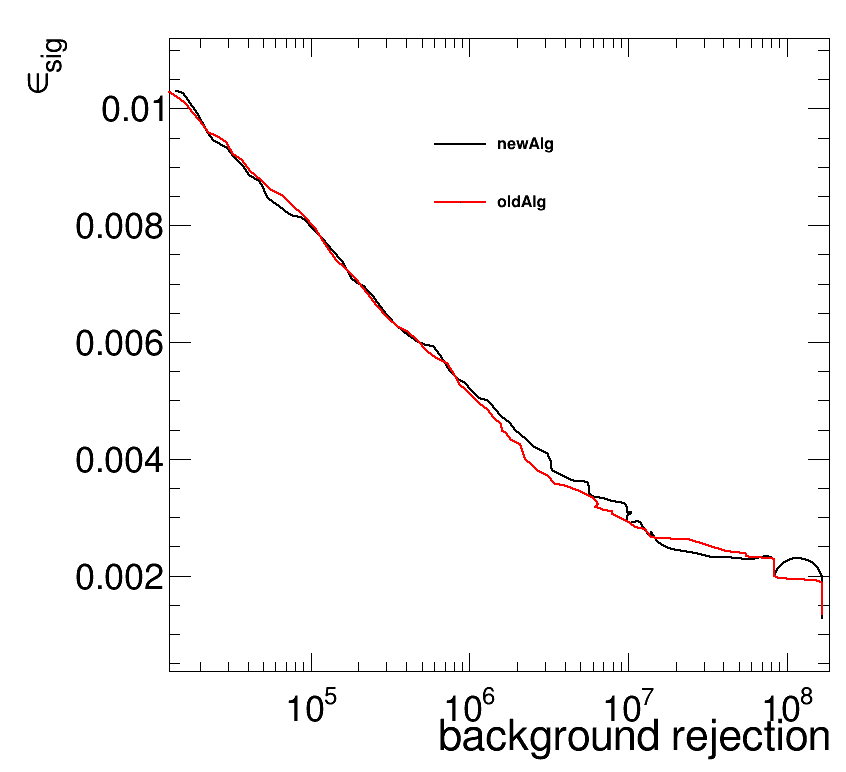

In [26]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.5,0.70,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}


# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# # moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']

# var = [nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['hit removal', 'cluster removal', 'hit removal + ME11/12 veto','cluster removal + ME11/12 veto']


# # with and without muon veto
var = [nCsc_JetVetoCluster0p4, nCsc_JetMuonVetoCluster0p4, 
       nCsc_JetVetoCluster0p4_Me1112Veto,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
name =['nCsc_JetVetoCluster0p4', 'nCsc_JetMuonVetoCluster0p4', 
       'nCsc_JetVetoCluster0p4_Me1112Veto','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
legend = ['jet veto', 'jet & muon veto', 'jet veto + ME11/12 veto','jet & muon veto + ME11/12 veto', ]

#calo vs. pf
# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_caloJetMuonVetoCluster0p4_Me1112Veto', 'nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto']
# legend = ['pf jet & muon veto + ME11/12 veto','calo jet & muon veto + ME11/12 veto','pf & calo jet & muon veto + ME11/12 veto']





# #compare sum vs. most populated cluster

# var = [nCsc0_JetMuonVetoCluster0p4, nCsc0_JetMuonVetoCluster0p4_Me1112Veto, 
#        nCsc_JetMuonVetoCluster0p4,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name = ['nCsc0_JetMuonVetoCluster0p4', 'nCsc0_JetMuonVetoCluster0p4_Me1112Veto', 
#        'nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['jet & muon veto, largest cluster', 'jet & muon veto + ME11/12 veto, largest cluster', 
# 'jet & muon veto, all clusters', 'jet & muon veto + ME11/12 veto, all clusters']
legend = ['20 GeV Muon Veto','15 GeV Muon Veto','10 GeV Muon Veto','5 GeV Muon Veto']
name = ['muonveto20','muonveto15','muonveto10','muonveto5']

legend = ['10 GeV Jet Veto','15 GeV Jet Veto']
label = ['jetveto10','jetveto15']

legend =['PUPPI','PF']
label = ['PUPPI','PF']

var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_caloJetMuonVetoCluster0p4_Me1112Veto]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_caloJetMuonVetoCluster0p4_Me1112Veto']
legend = ['pf jet & muon veto + ME11/12 veto','calo jet & muon veto + ME11/12 veto']

legend = ['PUPPI Jet','PFJet','CaloJet']

var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto']
legend = ['lessstats','morestats',]
label = ['lessstats','morestats']
legend = ['newAlg','oldAlg',]
label = ['newAlg','oldAlg']


thre = np.array(range(250))
for i in range(len(label)):
    for j in range(len(var)):
        qcd_key = 'WJetsToLNu_'+label[i]
        sig_k = 'bbbb_'+label[i]
        eff = {}
        keys = [qcd_key,sig_k]
        for k in keys:
            v = var[j][k]
            eff[k] = []
            for th in thre:
                sample = k.split('_')[0]
                eff[k].append(1.0*np.sum(weight[k][v>th])/(xsec[sample]*lumi))
            eff[k] = np.array(eff[k])
    #     Plotting ROC curve
        eff[sig_k] = eff[sig_k][eff[qcd_key] > 0]
        eff[qcd_key] = eff[qcd_key][eff[qcd_key] > 0]
    #     print(eff[qcd_key])
        print(eff[qcd_key].shape, eff[sig_k].shape)
        gr[name[j]+label[i]] = create_TGraph(np.reciprocal(eff[qcd_key]),eff[sig_k],axis_title = ['background rejection','#epsilon_{sig}'])
    #     gr[name[i]].SetLineColor(std_color_list[int(i/2)])
    #     gr[name[i]].SetLineStyle(std_color_list[i%2])
        gr[name[j]+label[i]].SetLineColor(std_color_list[i+j])
        gr[name[j]+label[i]].SetLineStyle(std_color_list[0])
        gr[name[j]+label[i]].SetLineWidth(2)
        gr[name[j]+label[i]].GetYaxis().SetTitleOffset(1.5)

        gr[name[j]+label[i]].GetYaxis().SetRangeUser(0,0.001)
    #     gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
    #         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


        leg.AddEntry(gr[name[j]+label[i]],legend[i+j])

        gr[name[j]+label[i]].Draw('ac' if i==0 else 'c')
        c.SetLeftMargin(0.2)
        leg.Draw()
        value = 0.005 #target signal efficiency
        print(eff[qcd_key].shape, eff[sig_k].shape)
        ind = np.abs(eff[sig_k]-value).argmin()
        print(sig_k)
#         print(eff[sig_k])
        print(ind,len(eff[sig_k]))
#         ind = 110
        print(1.0/eff[qcd_key][ind])
#         print(name[i],eff[sig_k][ind])
#         print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')




# nCsc histogram

In [ ]:
# output_root = rt.TFile("output.root","RECREATE")

start_t = time.time()
#ROC curve
c.Delete()
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.36,0.65,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
# var = [nCsc,nCsc_recoJetVeto0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto]
# name = ['nCsc','nCsc_recoJetVeto0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto']
# legend = ['','recoJetVeto #Delta R = 0.4',
#          'recoJetVeto #Delta R = 0.4, Me11 12Veto']


# var = [nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']

# var = [nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = [ 'hit removal + ME11/12 veto','cluster removal + ME11/12 veto']

var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto, 
      nCsc_JetVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',
        'nCsc_JetVetoCluster0p4_Me1112Veto']
legend = ['jet & muon veto + ME11/12 veto', 
          'jet veto + ME11/12 veto']


#calojet vs pf
# var = [ nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_caloJetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
# legend = ['calo jet & muon veto + ME11/12 veto', 
#           'pf jet & muon veto + ME11/12 veto',]

# pf vs. calo&pf
# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto']
# legend = ['pf jet & muon veto + ME11/12 veto','pf & calo jet & muon veto + ME11/12 veto']


# var = [ nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetVetoCluster0p4_Me1112Veto,]
# name = ['nCsc_caloJetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['calo jet & muon veto + ME11/12 veto', 
#           'pf jet veto + ME11/12 veto']
# var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto, nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto','nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',]
# legend = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto','recoJetVeto #Delta R = 0.4','All clusters with JetVeto']





# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']

#compare sum vs. most populated cluster
# var = [nCsc0_JetMuonVetoCluster0p4, nCsc0_JetMuonVetoCluster0p4_Me1112Veto, 
#        nCsc_JetMuonVetoCluster0p4,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name = ['nCsc0_JetMuonVetoCluster0p4', 'nCsc0_JetMuonVetoCluster0p4_Me1112Veto', 
#        'nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['jet & muon veto, largest cluster', 'jet & muon veto + ME11/12 veto, largest cluster', 
# 'jet & muon veto, all clusters', 'jet & muon veto + ME11/12 veto, all clusters']



max_y = 0
bkg_nCsc = []
var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_caloJetMuonVetoCluster0p4_Me1112Veto]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_caloJetMuonVetoCluster0p4_Me1112Veto']
legend = ['pf jet & muon veto + ME11/12 veto','calo jet & muon veto + ME11/12 veto']

# legend = ['PUPPI Jet','PFJet','CaloJet']


# for i,v in enumerate(var):
for k in tree_bkg.keys():
    print(k)
#     if not k[-2:]=='PF'and i==1:continue
#         cond = np.logical_and(event_Me1112Veto[k],event_recoJetVeto0p4[k])
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])
    if k[-2:]=='PF':
        h[k+'calo'] = create_TH1D( nCsc_caloJetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])
        if k[:4] == 'bbbb':
            h[k+'calo'].SetLineColor(std_color_list[0])
        else:
            h[k+'calo'].SetLineColor(std_color_list[1])
        leg.AddEntry(h[k+'calo'],sample+"_CALO")
        h[k+'calo'].SetLineStyle(3)
        h[k+'calo'].SetMinimum(1)
        h[k+'calo'].Draw("same hist")
        sample = k.split('_')[0]
        
    #     print(v[k][:10])
    if k[:4] == 'bbbb':
        h[k].SetLineColor(std_color_list[0])
    else:
        h[k].SetLineColor(std_color_list[1])
    if k[-2:] == 'PF':
        h[k].SetLineStyle(1)
    else:
        h[k].SetLineStyle(2)
    currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
    if currentMax > max_y:
        max_y = currentMax
        h[k].SetMaximum(5*currentMax)
    h[k].SetMinimum(1)

#         if k == qcd_key and i == 0:
#             r = h[k+str(i)].Fit('expo', 'LRSQ+', '', 10,100)
#             print(r.Get())
#             h[k+str(i)].GetFunction("expo").SetLineColor(std_color_list[2])
#             h[k+str(i)].GetFunction("expo").SetLineWidth(2)
#             for j in range(300):
#                 bkg_nCsc.append(h[k+str(i)].GetFunction("expo").Eval(j))
#             bkg_nCsc = np.array(bkg_nCsc)
#         c.cd()
    
        

        
#         output_root.cd()
#         h[k+str(i)].Write(k+"_"+name[i])
    #     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)

    h[k].Draw("same hist")
    leg.AddEntry(h[k],k)

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')
# output_root.Close()

print(time.time()-start_t)



In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.30,0.75,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']

# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# # moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']



max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
for k in tree_bkg.keys():
    cond = np.logical_and(event_recoJetVeto0p4[k], event_Me1112Veto[k])    
    h[k+'event'] = create_TH1D( nCsc[k][cond], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k][cond])
    h[k+'jetveto'] = create_TH1D( nCsc_recoJetVeto0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])

    if k == 'bbbb':
        h[k+'event'].SetLineColor(std_color_list[0])
        h[k+'jetveto'].SetLineColor(std_color_list[0])

    else:
        h[k+'event'].SetLineColor(std_color_list[1])
        h[k+'jetveto'].SetLineColor(std_color_list[1])

    h[k+'event'].SetLineStyle(0)
    h[k+'jetveto'].SetLineStyle(3)

#     currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
#     if currentMax > max_y:
#         max_y = currentMax
    h[k+'event'].SetMaximum(5*10e6)
    h[k+'event'].SetMinimum(1)

#         h[k+str(i)].SetMinimum(1)
    h[k+'event'].Draw("same hist")
    h[k+'jetveto'].Draw("same hist")
#     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(h[k+'event'],k+" event veto #Delta R = 0.4, Me11 12Veto")
    leg.AddEntry(h[k+'jetveto'],k+" recoJetVeto #Delta R = 0.4, Me11 12Veto")

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# event yield vs. ncsc

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.45,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
h = {}
leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']
var = [nCsc_JetMuonVetoCluster0p4, nCsc_JetMuonVetoCluster0p4_Me1112Veto, 
      nCsc_JetVetoCluster0p4_Me1112Veto,nCsc_JetVetoCluster0p4]
name = ['nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto',
        'nCsc_JetVetoCluster0p4_Me1112Veto','nCsc_JetVetoCluster0p4']
legend = ['jet & muon veto', 'jet & muon veto + ME11/12 veto', 
          'jet veto + ME11/12 veto','jet veto']
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
threshold = np.array(list(range(300)))
for i in range(len(var)):
    event_count = {}
    for k in tree_bkg.keys():
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
    cond = np.logical_not(event_count[k] == 0)
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(threshold[cond], event_count[sig_k][cond],  axis_title=['nCsc', 'Signal Yield'])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 300)
    h[sig_k+str(i)].SetMaximum(10000)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 50000)
    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')
leg.Draw()

c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# significance

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']
var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
legend = [ 'jet & muon veto + ME11/12 veto',]

bkg_k = 'WJetsToLNu'
sig_k = 'bbbb'
br = 0.1

threshold = list(range(300))
threshold = np.array(list(range(300)))
# print(threshold)
for i in range(len(var)):
    event_count = {}
    
    for k in tree_bkg.keys():
        event_count[k] = []
        for th in threshold:
            if k == qcd_key:
                event_count[k].append(np.sum(bkg_nCsc[th:]))
#                 print(th,np.sum(bkg_nCsc[th:]))
            else:
                event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(ncsc, sig,  axis_title=['nCsc', 'Significnace'])
    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 300)
    h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 20)


    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




leg.Draw()
# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# DBSCAN

In [ ]:
allclusters = {}
cluster0 = {}
for k,v in tree_bkg.items():
    allclusters[k] = []
    cluster0[k] = []
    for i in range(len(cscX[k])):
        data_segments = np.dstack((cscX[k][i], cscY[k][i], cscZ[k][i]))
        db = skc.DBSCAN(eps=200, min_samples=10).fit(data_segments)
        dblabels = db.labels_
        print(set(dblabels))
        unique_db, counts_db = np.unique(dblabels, return_counts=True)
        print(dict(zip(unique_db, counts_db)))

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_db = len(set(dblabels)) - (1 if -1 in dblabels else 0)
        allclusters[k].append(n_clusters_db)
        n_noise_db = list(dblabels).count(-1)
        print(n_noise_db)

# Time response in rechit cut

# Time response in ECAL energy bins

# Time response in t_gen